In [268]:
%matplotlib widget

from sklearn.datasets import load_diabetes
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import math

In [269]:
np.set_printoptions(precision=15)

diabetes = load_diabetes(scaled=True) # enable Feature Scaling
data = diabetes.data # (m x n) (examples x features)

severity = diabetes.target.reshape((-1,1)) # output of severity of diabetes or disease progression
# mx1

print(data.dtype, severity.dtype) # show datatypes of input and output
print(data.shape) # show shape of input
print(diabetes.feature_names) # show feature names associated with input
print(data)# show data itself

float64 float64
(442, 10)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[[ 0.038075906433423  0.050680118739819  0.061696206518683 ...
  -0.002592261998183  0.019907486170463 -0.017646125159804]
 [-0.001882016527791 -0.044641636506989 -0.051474061238801 ...
  -0.039493382874093 -0.068331547093973 -0.092204049626824]
 [ 0.085298906296675  0.050680118739819  0.04445121333659  ...
  -0.002592261998183  0.002861309289833 -0.025930338989473]
 ...
 [ 0.041708444884442  0.050680118739819 -0.015906262800734 ...
  -0.011079519799643 -0.046882534152732  0.015490730158872]
 [-0.045472477940024 -0.044641636506989  0.039062152967186 ...
   0.026559623493786  0.044528728819971 -0.025930338989473]
 [-0.045472477940024 -0.044641636506989 -0.073030302716417 ...
  -0.039493382874093 -0.004221513938108  0.003064409414368]]


In [270]:
def predict(w,b,x):
    prediction = np.matmul(x, w) + b
    return prediction

In [271]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    
    prediction = np.matmul(x, w) + b
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

The goal for now is to try ternary search on the parameters of w. This is a really cool technique that is much faster than gradient descent but needs to meet some criteria first. Firstly, the number of dimensions can't be too large. Secondly, the range of the prediction function times the dimension count can't be too large. Rule 1 and Rule 2 go hand in hand and can make this technique really bad. Lastly and most important, the function has to be unimodal (or convex). If any of these can't be met, then it's better to use a gradient descent approach and this will converge correctly. How does ternary search work? 

Ternary search is a technique to find the maximum or minimum of a unimodal function. Since our cost function now is very simple in terms of MSE and parabolic in shape, it actually is unimodal. Instead of computing gradients and updating the weights little by little, we instead ternary search on each individual weight while keeping other weights fixed. This drastically reduces search space instead of using gradient descent because we're removing at least 1/3 of the search space per weight each iteration of ternary search. It is a very powerful technique if used properly.

In [272]:
def ternary_search(func, l, r, max_iter=1000, epsilon=1e-13):
    it = 0
    newcosts = np.empty(0)

    while abs(r - l) > epsilon and it <= max_iter:
        left_third = l + (r - l) / 3
        right_third = r - (r - l) / 3

        fl = func(left_third)
        fr = func(right_third)

        if fl < fr:
            r = right_third
            newcosts = np.append(newcosts, fr)
        else:
            l = left_third
            newcosts = np.append(newcosts, fl)

        it += 1
    return newcosts

In [273]:
def perform_search(x,y,search_function):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    w = np.zeros((n,1)) # n features
    b = 0.0
    # initialize model parameters

    costs = np.empty(0)

    cur_weight_index = 0 # index to choose which weight to update

    out_max = np.max(y)
    out_min = -out_max # ranges for search

    def eval_weights_cost(inp):
        w[cur_weight_index][0] = inp
        return mse_cost(w, b, x, y)

    def eval_intercept_cost(inp):
        nonlocal b
        b = inp
        return mse_cost(w, b, x, y)

    # go through the intercept now
    new_costs = ternary_search(eval_intercept_cost, out_min, out_max) # perform the search 
    costs = np.append(costs, new_costs) # update costs

    for i in range(n): # go through all weights
        new_costs = ternary_search(eval_weights_cost, out_min, out_max) # perform the search 

        costs = np.append(costs, new_costs) # update costs
        cur_weight_index += 1 # go to next weight index
    return w, b, costs

In [274]:
w, b, costs = perform_search(data, severity, ternary_search)

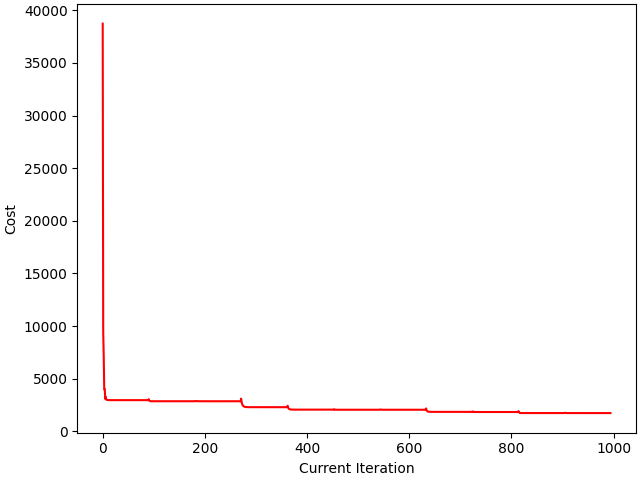

In [275]:
iteration = np.arange(0, costs.shape[0])

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")

cost_graph.plot(iteration, costs, color="r")

In [276]:
print("w:", w.reshape((-1)))
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [ 304.1830604642041     16.86748049220956   345.99999999999994
  345.99999999999994    93.23779880901408   -25.478817026716342
 -345.99999999999915   107.6907913653828    296.3309916517619
  -45.931294977094815]
b: 152.13348440463068
1st Cost: 38734.19167923582
Nth Cost: 1736.1518074944859


This is very interesting. Firstly, the cost dropped rapidly when updating the intercept so clearly the intercept is very significant to the cost. Then when updating the weights it didn't drop as much but still reduced a bit. The bigger issue however is how the cost is bigger than the gradient descent version which ranks at 1400 while this is 1700. This is primarily due to the precision issue where two very close inputs lead to the same output. I need to figure out a way to avoid precisions. One post suggests that golden section search could be used for better accuracy instead. 

In [277]:
def golden_section_search(func, l, r, max_iter=1000, epsilon=1e-12):
    it = 0
    newcosts = np.empty(0)

    gr = (math.sqrt(5) + 1) / 2
    while abs(r - l) > epsilon and it <= max_iter:
        left_third = l + (r - l) / gr
        right_third = r - (r - l) / gr

        fl = func(left_third)
        fr = func(right_third)

        if fl < fr:
            r = right_third
            newcosts = np.append(newcosts, fr)
        else:
            l = left_third
            newcosts = np.append(newcosts, fl)
    it += 1

    return newcosts

In [278]:
w, b, costs = perform_search(data, severity, golden_section_search)

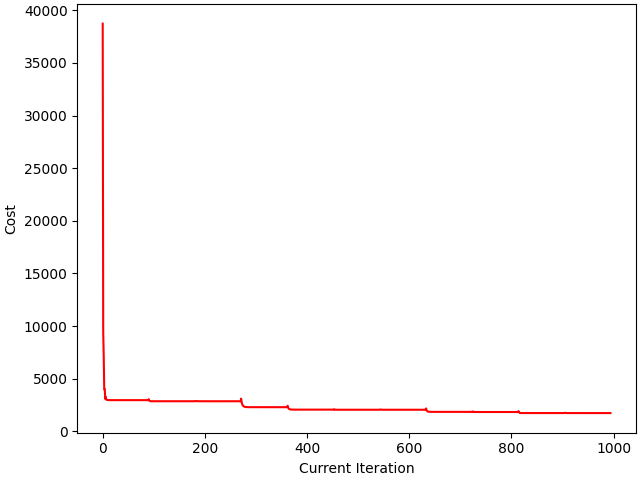

In [279]:
iteration = np.arange(0, costs.shape[0])

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")

cost_graph.plot(iteration, costs, color="r")

In [280]:
print("w:", w.reshape((-1)))
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [ 304.1830604642041     16.86748049220956   345.99999999999994
  345.99999999999994    93.23779880901408   -25.478817026716342
 -345.99999999999915   107.6907913653828    296.3309916517619
  -45.931294977094815]
b: 152.13348440463068
1st Cost: 38734.19167923582
Nth Cost: 1736.1518074944859


Same result with gss as ternary search. So for sure there is a precision issue. I tried feature scaling the output as well to make sure values don't blow up but doesn't seem to help as precision issues will still be a thing no matter the range of values.